In [1]:
import gc
from datetime import timedelta
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Auto-detect the width
pd.set_option('display.max_colwidth', None)

In [2]:
file_pattern = '/kaggle/input/neo-bank-non-sub-churn-prediction/train_*.parquet' 
all_files = glob.glob(file_pattern)
all_files

['/kaggle/input/neo-bank-non-sub-churn-prediction/train_2008.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2020.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2019.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2010.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2011.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2016.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2017.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2015.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2009.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2021.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2014.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2022.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2018.parquet',
 '/kaggle/input/neo-bank-non-sub-churn-prediction/train_2023.parquet',
 '/kag

In [3]:
train_df = pd.concat([pd.read_parquet(file) for file in all_files], ignore_index=True)
test_file = '/kaggle/input/neo-bank-non-sub-churn-prediction/test.parquet' 
test_df = pd.read_parquet(test_file)

In [4]:
print(train_df.shape)
print(test_df.shape)

(3926058, 26)
(1360472, 27)


In [5]:
test_df.columns

Index(['Id', 'customer_id', 'interest_rate', 'name', 'country',
       'date_of_birth', 'address', 'date', 'atm_transfer_in',
       'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
       'crypto_in', 'crypto_out', 'bank_transfer_in_volume',
       'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume',
       'complaints', 'touchpoints', 'csat_scores', 'tenure', 'from_competitor',
       'job', 'churn_due_to_fraud', 'Usage', 'model_predicted_fraud'],
      dtype='object')

In [6]:
##Dropping useless columns since not present in train data -> 'Usage'
test_df.drop(columns=['Usage'], inplace = True)

In [7]:
#Concating test and train data to perform EDA and feature engineering
combined_df = pd.concat([train_df,test_df], axis=0)
combined_df.shape

(5286530, 26)

In [8]:
combined_df.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",0,False,Amenity horticulturist,False,False
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",1,False,Amenity horticulturist,False,False
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",2,False,Amenity horticulturist,False,False
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",3,False,Amenity horticulturist,False,False
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,"[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",4,False,Amenity horticulturist,False,False


FEATURE ENGINEERING

In [9]:
# ##Extracting csat_scores into diff cols

# import ast

# def extract_csat_scores(row):
#     if isinstance(row, dict):
#         return {f"csat_{k}": (v if v is not None else 0) for k, v in row.items()}
#     try:
#         parsed_row = json.loads(row)
#         return {f"csat_{k}": (v if v is not None else 0) for k, v in parsed_row.items()}
#     except Exception as e:
#         print(f"Error parsing row: {row}, {e}")
#         return {}


# # Apply to the dataset
# csat_features = combined_df['csat_scores'].apply(extract_csat_scores).apply(pd.Series)
# combined_df = pd.concat([combined_df, csat_features], axis=1)


# Process CSAT (Customer Satisfaction) scores:
# We expand the 'csat_scores' column (which is likely a list or dictionary) into separate columns

df_expanded = combined_df['csat_scores'].apply(lambda x: pd.Series(x) if isinstance(x, dict) else None)

# Concatenate the expanded columns back to the original dataframe
# Then, drop the original 'csat_scores' column
combined_df = pd.concat([combined_df, df_expanded], axis=1)


In [10]:
df_expanded

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,appointment,email,phone,whatsapp
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
1360467,NaN,NaN,NaN,NaN
1360468,NaN,NaN,NaN,NaN
1360469,NaN,NaN,NaN,NaN
1360470,NaN,NaN,NaN,NaN


In [11]:
combined_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",0,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",1,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",2,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",3,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,"[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",4,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360467,7547787,47228,0.0,Tammy Sanchez,Germany,1988-10-13,"2035 John Forks Suite 685\nThompsonport, FL 96738 Germany",2026-12-31,0,0,2880,10,4,5,3396.140418,237.798981,237.128541,97.253620,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",791,False,"Education officer, community",False,False,NaN,NaN,NaN,NaN
1360468,7547788,26232,2.5,Deborah Booth,Belgium,1961-01-16,"837 Sanchez Village Apt. 410\nLake Rebecca, TX 78981 Belgium",2026-12-31,0,0,12,8,18,30,41.239517,29.096285,106.694795,29.715660,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",2329,False,"Therapist, sports",False,False,NaN,NaN,NaN,NaN
1360469,7547789,39233,2.5,Erin Dudley,Denmark,2000-07-03,"627 Reese Heights Apt. 485\nPort Tamaraview, OK 16328 Denmark",2026-12-31,0,0,4312,12,1,3,1246.168297,716.303181,259.640213,94.846312,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",1550,False,unemployed,False,False,NaN,NaN,NaN,NaN
1360470,7547790,87197,2.5,Tracy Santana,Norway,1946-11-11,"444 Michael Centers Apt. 014\nSouth Daniel, PA 08755 Norway",2026-12-31,0,0,3120,6,6,4,3073.316455,276.646651,201.450474,67.410133,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",375,False,Civil Service fast streamer,False,False,NaN,NaN,NaN,NaN


In [12]:
combined_df = combined_df.drop(columns=['csat_scores'])

In [13]:
combined_df['touchpoints'] = combined_df['touchpoints'].apply(len)

In [14]:
combined_df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,0,0,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,0,1,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,0,2,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,0,3,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,3,4,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN


In [15]:
combined_df['appointment'].unique()

array([nan,  8.,  6.,  9.,  5.,  4.,  7., 10.,  3.,  2.,  1.])

In [16]:
combined_df.columns

Index(['Id', 'customer_id', 'interest_rate', 'name', 'country',
       'date_of_birth', 'address', 'date', 'atm_transfer_in',
       'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
       'crypto_in', 'crypto_out', 'bank_transfer_in_volume',
       'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume',
       'complaints', 'touchpoints', 'tenure', 'from_competitor', 'job',
       'churn_due_to_fraud', 'model_predicted_fraud', 'appointment', 'email',
       'phone', 'whatsapp'],
      dtype='object')

In [17]:
train_df.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",0,False,Amenity horticulturist,False,False
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",1,False,Amenity horticulturist,False,False
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",2,False,Amenity horticulturist,False,False
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,[],"{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",3,False,Amenity horticulturist,False,False
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,"[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': None, 'whatsapp': None}",4,False,Amenity horticulturist,False,False


WE can use the above to check catboost algor with encoding

In [18]:
#Categorical encoding
df = combined_df.copy()
cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
unique_values = {col: df[col].nunique() for col in cat_features}
unique_values


{'name': 104786,
 'country': 25,
 'date_of_birth': 24804,
 'address': 165158,
 'job': 640}

In [19]:
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], errors='coerce')
invalid_date_count = df['date_of_birth'].isna().sum()
invalid_date_count


0

In [20]:
df['age'] = (pd.to_datetime('today') - df['date_of_birth']).dt.days // 365
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp,age
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,0,0,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,0,1,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,0,2,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,0,3,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,3,4,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70


In [21]:
df['date'] = pd.to_datetime(df['date'])
last_transaction_dates = df.groupby('customer_id')['date'].max().reset_index()
df = df.merge(last_transaction_dates, on='customer_id', how='left', suffixes=('', '_last'))
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp,age,date_last
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,0,0,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70,2026-02-27
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,0,1,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70,2026-02-27
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,0,2,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70,2026-02-27
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,0,3,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70,2026-02-27
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,3,4,False,Amenity horticulturist,False,False,NaN,NaN,NaN,NaN,70,2026-02-27


In [22]:
## USED FOR RULE CALCULATION TO PREDICT CHURN
filtered_df = df[(df['customer_id'] <= 100000) & ((df['date'] - pd.to_datetime('today')).dt.days > 365)]
filtered_df['customer_id'].nunique()

52342

In [23]:

# Initialize LabelEncoder
label_encoders = {}

# Apply Label Encoding to each high-cardinality categorical feature
for col in ['address', 'job']:
    encoder = LabelEncoder()
    df[col + '_encoded'] = encoder.fit_transform(df[col])
    label_encoders[col] = encoder  # Save encoder for inverse transformation if needed


In [24]:
for col in ['churn_due_to_fraud', 'model_predicted_fraud','from_competitor']:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    label_encoders[col] = encoder  # Save encoder for inverse transformation if needed

In [25]:
df = pd.get_dummies(df, columns=['country'], prefix='country')

In [26]:
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,customer_id,interest_rate,name,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp,age,date_last,address_encoded,job_encoded,country_Austria,country_Belgium,country_Bulgaria,country_Czech Republic,country_Denmark,country_Estonia,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Latvia,country_Lithuania,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Romania,country_Slovakia,country_Spain,country_Sweden,country_Switzerland,country_USA
0,1,1,3.5,Yolanda Parker,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,0,0,0,Amenity horticulturist,0,0,NaN,NaN,NaN,NaN,70,2026-02-27,28482,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,6,1,3.5,Yolanda Parker,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,0,1,0,Amenity horticulturist,0,0,NaN,NaN,NaN,NaN,70,2026-02-27,28482,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,16,1,3.5,Yolanda Parker,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,0,2,0,Amenity horticulturist,0,0,NaN,NaN,NaN,NaN,70,2026-02-27,28482,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,31,1,3.5,Yolanda Parker,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,0,3,0,Amenity horticulturist,0,0,NaN,NaN,NaN,NaN,70,2026-02-27,28482,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,50,1,3.5,Yolanda Parker,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh, GU 16541 Lithuania",2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,3,4,0,Amenity horticulturist,0,0,NaN,NaN,NaN,NaN,70,2026-02-27,28482,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [27]:
df.drop(columns=['address','name','date_of_birth','job'], inplace= True)

In [28]:
df.drop(columns=['Id'], inplace= True)

In [29]:
df.columns

Index(['customer_id', 'interest_rate', 'date', 'atm_transfer_in',
       'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
       'crypto_in', 'crypto_out', 'bank_transfer_in_volume',
       'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume',
       'complaints', 'touchpoints', 'tenure', 'from_competitor',
       'churn_due_to_fraud', 'model_predicted_fraud', 'appointment', 'email',
       'phone', 'whatsapp', 'age', 'date_last', 'address_encoded',
       'job_encoded', 'country_Austria', 'country_Belgium', 'country_Bulgaria',
       'country_Czech Republic', 'country_Denmark', 'country_Estonia',
       'country_Finland', 'country_France', 'country_Germany',
       'country_Greece', 'country_Hungary', 'country_Ireland', 'country_Italy',
       'country_Latvia', 'country_Lithuania', 'country_Netherlands',
       'country_Norway', 'country_Poland', 'country_Portugal',
       'country_Romania', 'country_Slovakia', 'country_Spain',
       'country_Sweden', 'coun

In [30]:
features_nan=[feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtypes!='O']

# for feature in features_nan:
#     print("{}: {}% missing values".format(feature,np.round(df[feature].isnull().mean(),4)))
features_nan

['appointment', 'email', 'phone', 'whatsapp']

No missing data - HOORAY
No no there is missing data

In [31]:
df.shape

(5286530, 52)

In [32]:
combined_df['appointment'].unique()
# Since there is no 0 as a valueu in these csat encoded columns
# replacing nan values iwth 0

array([nan,  8.,  6.,  9.,  5.,  4.,  7., 10.,  3.,  2.,  1.])

In [33]:
df[features_nan] = df[features_nan].fillna(0)

In [34]:
features_nan=[feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtypes!='O']

# for feature in features_nan:
#     print("{}: {}% missing values".format(feature,np.round(df[feature].isnull().mean(),4)))
features_nan

[]

NOW there are no features with numerical null value

In [35]:
features_nan=[feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtypes=='O']

# for feature in features_nan:
#     print("{}: {}% missing values".format(feature,np.round(df[feature].isnull().mean(),4)))
features_nan

[]

In [36]:
# Droppping the address colummn as label encoding treats 1 address better than the other 
df = df.drop(columns=['address_encoded'])

In [37]:
df.shape

(5286530, 51)

No categorical feature with null value

SEPARATION OF TEST AND TRAIN

In [38]:
train_df_mod =  df.iloc[:3926058]
test_df_mod = df.iloc[3926058:]
print(test_df_mod.shape)
print(train_df_mod.shape)

(1360472, 51)
(3926058, 51)


In [39]:
numerical_features = [[feature for feature in df.columns if df[feature].dtype != 'object']]
numerical_features

[['customer_id',
  'interest_rate',
  'date',
  'atm_transfer_in',
  'atm_transfer_out',
  'bank_transfer_in',
  'bank_transfer_out',
  'crypto_in',
  'crypto_out',
  'bank_transfer_in_volume',
  'bank_transfer_out_volume',
  'crypto_in_volume',
  'crypto_out_volume',
  'complaints',
  'touchpoints',
  'tenure',
  'from_competitor',
  'churn_due_to_fraud',
  'model_predicted_fraud',
  'appointment',
  'email',
  'phone',
  'whatsapp',
  'age',
  'date_last',
  'job_encoded',
  'country_Austria',
  'country_Belgium',
  'country_Bulgaria',
  'country_Czech Republic',
  'country_Denmark',
  'country_Estonia',
  'country_Finland',
  'country_France',
  'country_Germany',
  'country_Greece',
  'country_Hungary',
  'country_Ireland',
  'country_Italy',
  'country_Latvia',
  'country_Lithuania',
  'country_Netherlands',
  'country_Norway',
  'country_Poland',
  'country_Portugal',
  'country_Romania',
  'country_Slovakia',
  'country_Spain',
  'country_Sweden',
  'country_Switzerland',
  'cou

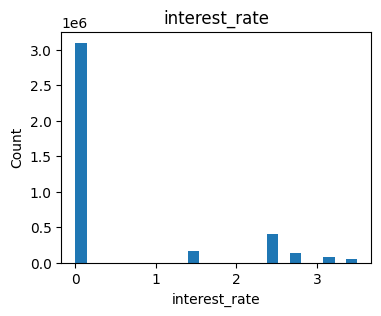

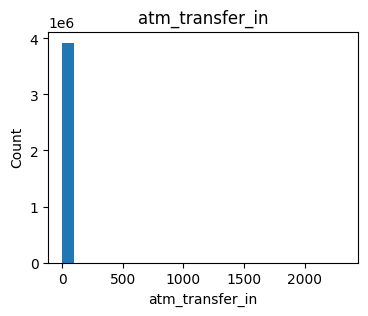

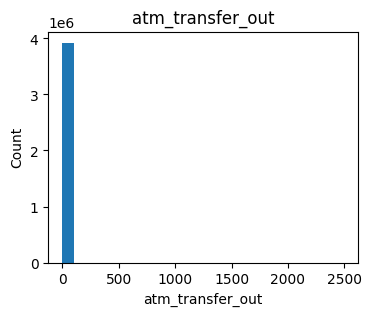

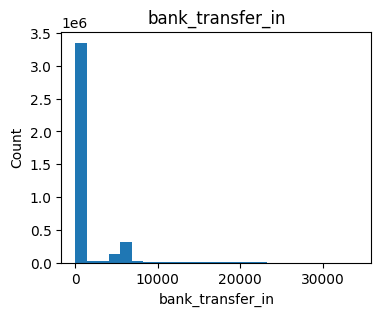

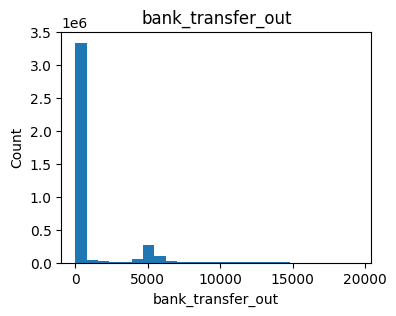

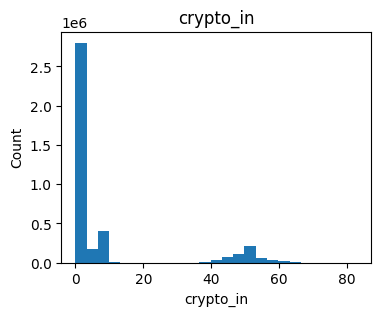

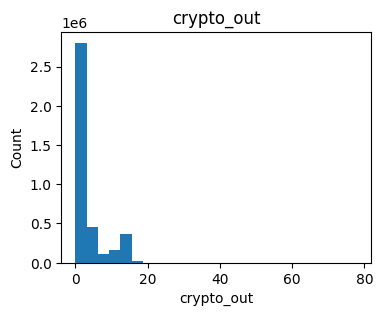

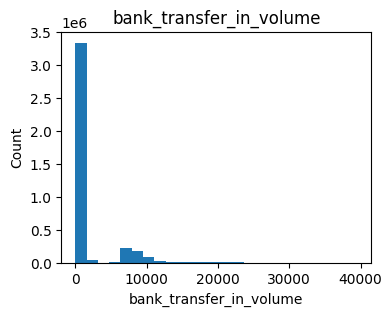

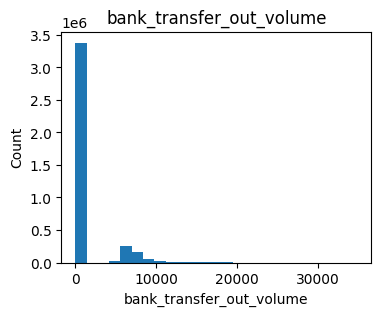

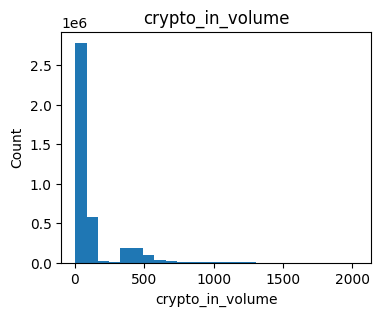

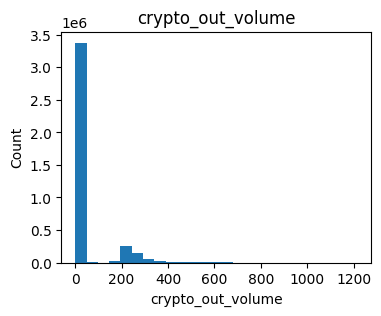

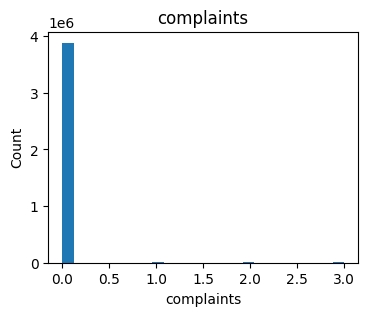

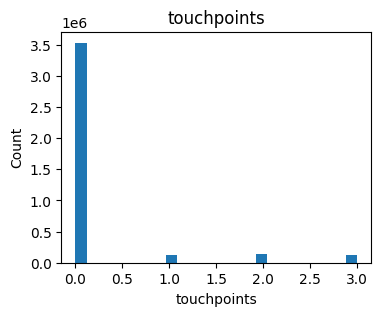

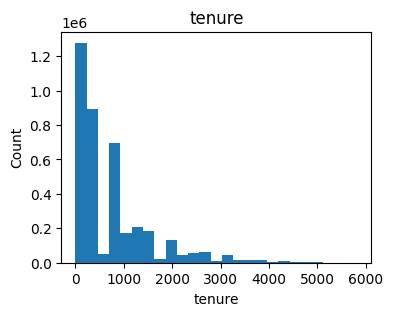

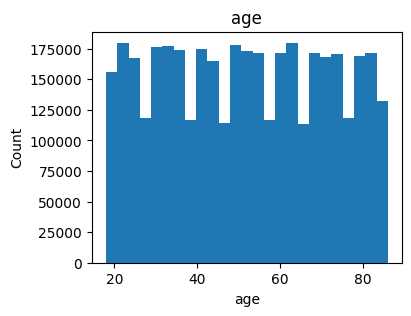

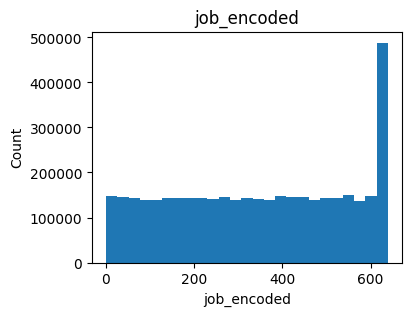

In [40]:
plot_features = [
  'interest_rate',
  'atm_transfer_in',
  'atm_transfer_out',
  'bank_transfer_in',
  'bank_transfer_out',
  'crypto_in',
  'crypto_out',
  'bank_transfer_in_volume',
  'bank_transfer_out_volume',
  'crypto_in_volume',
  'crypto_out_volume',
  'complaints',
  'touchpoints',
  'tenure',
  'age',
  'job_encoded']
for feature in plot_features:
    data = train_df_mod.copy()

    # Create a figure and axes with a larger size
    fig, ax = plt.subplots(figsize=(4, 3))  # Adjust the size (12, 8) as needed
    
    # Plot the histogram for the current feature
    ax.hist(data[feature], bins=25)
    
    # Add labels and title
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    ax.set_title(feature)
    
    # Display the plot
    plt.show()

In [41]:
# Understanding the plots
train_df_mod['atm_transfer_in'].value_counts()

atm_transfer_in
0       3885808
1         11550
2          8557
3          6345
4          4836
         ...   
1578          1
1688          1
1742          1
1485          1
1135          1
Name: count, Length: 744, dtype: int64

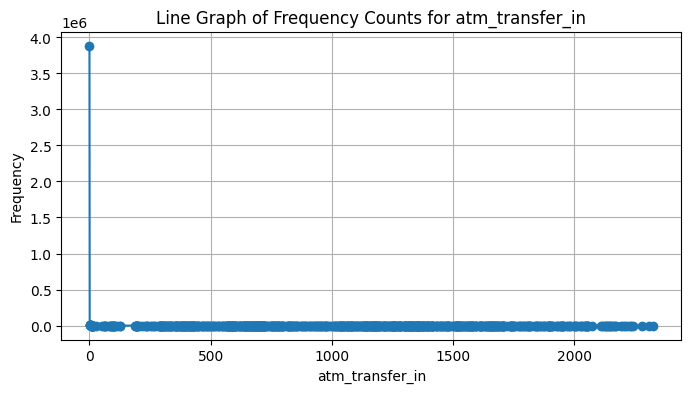

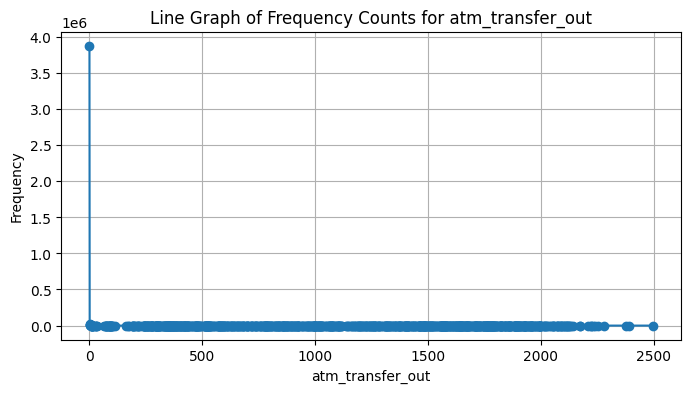

In [42]:
import matplotlib.pyplot as plt

# Iterate through the features and plot frequency counts as a line graph
atm_features = ['atm_transfer_in', 'atm_transfer_out']  # Features to visualize

for feature in atm_features:
    value_counts = train_df_mod[feature].value_counts().sort_index()  # Get frequency counts sorted by index
    plt.figure(figsize=(8, 4))  # Set figure size
    plt.plot(value_counts.index, value_counts.values, marker='o')  # Plot line graph with markers
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(f"Line Graph of Frequency Counts for {feature}")
    plt.grid(True)
    plt.show()


In [43]:
for feature in atm_features:
    if 0 in train_df_mod[feature].unique():
        pass
    else:
      train_df_mod[feature]=np.log(train_df_mod[feature])

In [44]:
for feature in atm_features:
    if 0 in test_df_mod[feature].unique():
        pass
    else:
      test_df_mod[feature]=np.log(test_df_mod[feature])

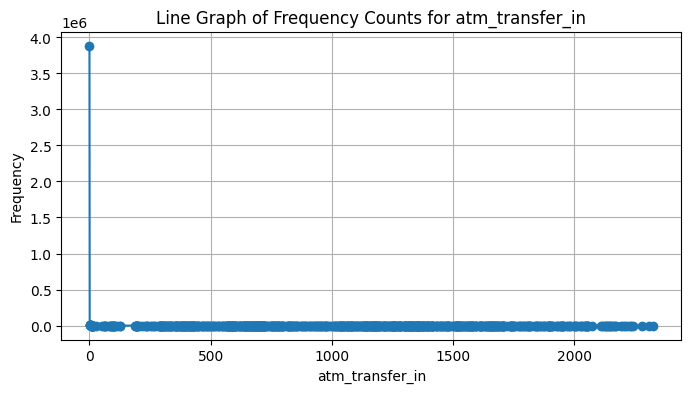

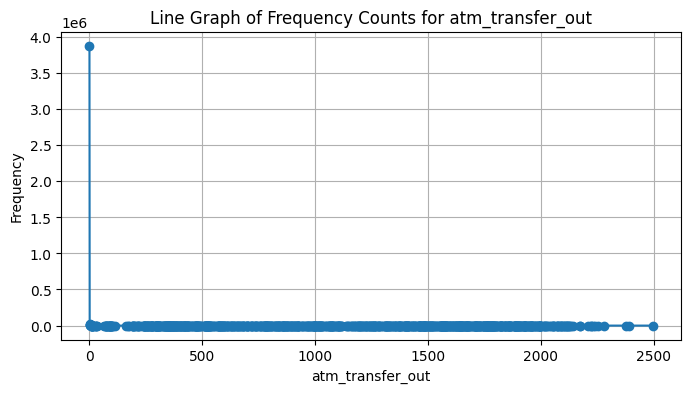

In [45]:
for feature in atm_features:
    value_counts = train_df_mod[feature].value_counts().sort_index()  # Get frequency counts sorted by index
    plt.figure(figsize=(8, 4))  # Set figure size
    plt.plot(value_counts.index, value_counts.values, marker='o')  # Plot line graph with markers
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(f"Line Graph of Frequency Counts for {feature}")
    plt.grid(True)
    plt.show()

OUTLIERS

In [46]:
# for feature in plot_features:
#     if 0 in train_df_mod[feature].unique():
#         pass
#     else:
#         data[feature]=np.log(train_df_mod[feature])
#         data.boxplot(column=feature)
#         plt.ylabel(feature)
#         plt.title(feature)
#         plt.show()
        
    

In [47]:
# Holding on the outliers for now

In [48]:
train_df_mod.head()

,customer_id,interest_rate,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,tenure,from_competitor,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp,age,date_last,job_encoded,country_Austria,country_Belgium,country_Bulgaria,country_Czech Republic,country_Denmark,country_Estonia,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Latvia,country_Lithuania,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Romania,country_Slovakia,country_Spain,country_Sweden,country_Switzerland,country_USA
0,1,3.5,2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,1,3.5,2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,0,1,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,1,3.5,2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,0,2,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,1,3.5,2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,0,3,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,1,3.5,2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,3,4,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


# **CHURN PREDICTION RULE**

In [49]:
# CHECKING HOW MANY CUSTOMERS ARE THERE
customers_count = train_df_mod.groupby('customer_id')['customer_id']
train_df_mod['customer_id'].nunique()

106179

In [50]:
# Making RULE  FOR CHURN 
## USED FOR RULE CALCULATION TO PREDICT CHURN
older_transactions = train_df_mod[((pd.to_datetime('today') - train_df_mod['date_last']).dt.days > 180)]

competitors_old = train_df_mod[((pd.to_datetime('today') - train_df_mod['date_last']).dt.days > 90) & (train_df_mod['from_competitor'] == 1)]

comp_complain = train_df_mod[(train_df_mod['complaints'] >= 2) & (train_df_mod['from_competitor'] == 1)]

older_transactions.count()



customer_id                 449462
interest_rate               449462
date                        449462
atm_transfer_in             449462
atm_transfer_out            449462
bank_transfer_in            449462
bank_transfer_out           449462
crypto_in                   449462
crypto_out                  449462
bank_transfer_in_volume     449462
bank_transfer_out_volume    449462
crypto_in_volume            449462
crypto_out_volume           449462
complaints                  449462
touchpoints                 449462
tenure                      449462
from_competitor             449462
churn_due_to_fraud          449462
model_predicted_fraud       449462
appointment                 449462
email                       449462
phone                       449462
whatsapp                    449462
age                         449462
date_last                   449462
job_encoded                 449462
country_Austria             449462
country_Belgium             449462
country_Bulgaria    

In [51]:
# Define the conditions
condition1 = (pd.to_datetime('today') - train_df_mod['date_last']).dt.days > 180
condition2 = ((pd.to_datetime('today') - train_df_mod['date_last']).dt.days > 90) & (train_df_mod['from_competitor'] == 1)
condition3 = (train_df_mod['complaints'] >= 2) & (train_df_mod['from_competitor'] == 1)

# Get records matching any of the conditions
churn_records = train_df_mod[condition1 | condition2 | condition3]

# Create the 'churn' column for these records
churn_records = churn_records.copy()
churn_records['churn'] = 1

# Create a default 'churn' column for the original DataFrame
train_df_mod['churn'] = 0

# Update the original DataFrame with the churn flag for the filtered records
train_df_mod.loc[churn_records.index, 'churn'] = 1


<ipython-input-51-9f47db7a7768>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_mod['churn'] = 0


In [52]:
train_df_mod.head()

,customer_id,interest_rate,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,tenure,from_competitor,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp,age,date_last,job_encoded,country_Austria,country_Belgium,country_Bulgaria,country_Czech Republic,country_Denmark,country_Estonia,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Latvia,country_Lithuania,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Romania,country_Slovakia,country_Spain,country_Sweden,country_Switzerland,country_USA,churn
0,1,3.5,2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
1,1,3.5,2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,0,1,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
2,1,3.5,2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,0,2,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
3,1,3.5,2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,0,3,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
4,1,3.5,2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,3,4,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0


In [53]:
train_df_mod.shape

(3926058, 52)

In [54]:
#  APPROACH 1 
# Use clusterign to group records based on their activity and classify 1 cluster as 0 for churn and otehrwise, and then on testing data classify into 1 cluster
# APPRAOCH 2 
# Make a formula to claculate pred of churn as 0 or 1 and then train the data accordingly and use CLASSFIICAITOn to classfiy test


In [55]:
features = ['interest_rate', 'date', 'atm_transfer_in',
       'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
       'crypto_in', 'crypto_out', 'bank_transfer_in_volume',
       'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume',
       'complaints', 'touchpoints', 'tenure', 'from_competitor',
       'churn_due_to_fraud', 'model_predicted_fraud', 'appointment', 'email',
       'phone', 'whatsapp', 'age', 'date_last', 'job_encoded',
       'country_Austria', 'country_Belgium', 'country_Bulgaria',
       'country_Czech Republic', 'country_Denmark', 'country_Estonia',
       'country_Finland', 'country_France', 'country_Germany',
       'country_Greece', 'country_Hungary', 'country_Ireland', 'country_Italy',
       'country_Latvia', 'country_Lithuania', 'country_Netherlands',
       'country_Norway', 'country_Poland', 'country_Portugal',
       'country_Romania', 'country_Slovakia', 'country_Spain',
       'country_Sweden', 'country_Switzerland', 'country_USA','churn']  # Add more features as necessary
X = train_df_mod[features]

In [56]:
# # Filter the DataFrame for rows where churn_due_to_fraud is True
# df_true_counts = combined_df[combined_df['churn_due_to_fraud'] == False].groupby('country')['churn_due_to_fraud'].count()

# # Display the result
# print(df_true_counts)


In [57]:
# #APPROACH 1 -> CLUSTER
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# kmeans = KMeans(n_clusters=2, random_state=42)

# train_df_mod['date_timestamp'] = train_df_mod['date'].astype(int) / 10**9  # Convert to seconds
# train_df_mod['date_last_timestamp'] = train_df_mod['date_last'].astype(int) / 10**9

# # Now drop the original date columns if no longer needed
# train_df_mod = train_df_mod.drop(['date', 'date_last'], axis=1)



In [58]:
train_df_mod

,customer_id,interest_rate,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,tenure,from_competitor,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp,age,date_last,job_encoded,country_Austria,country_Belgium,country_Bulgaria,country_Czech Republic,country_Denmark,country_Estonia,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Latvia,country_Lithuania,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Romania,country_Slovakia,country_Spain,country_Sweden,country_Switzerland,country_USA,churn
0,1,3.5,2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
1,1,3.5,2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,0,1,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
2,1,3.5,2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,0,2,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
3,1,3.5,2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,0,3,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
4,1,3.5,2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,3,4,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926053,13664,0.0,2013-12-31,4,0,701,12,1,1,730.424081,89.955215,45.546970,12.188301,0,1,0,0,0,0,0.0,0.0,0.0,0.0,60,2025-05-29,168,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0
3926054,13665,0.0,2013-12-31,0,0,130,31,4,1,639.621428,104.285413,56.098345,12.743148,0,0,0,0,0,0,0.0,0.0,0.0,0.0,71,2026-06-13,108,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0
3926055,13666,0.0,2013-12-31,0,0,628,72,1,1,669.880399,102.762738,46.569205,13.111458,0,0,0,0,0,0,0.0,0.0,0.0,0.0,49,2025-10-24,157,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0
3926056,13667,0.0,2013-12-31,0,0,1,2,2,2,27.732247,10.174721,48.731619,14.354938,0,0,0,1,0,0,0.0,0.0,0.0,0.0,65,2026-07-06,55,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0


In [59]:
X

,interest_rate,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,tenure,from_competitor,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp,age,date_last,job_encoded,country_Austria,country_Belgium,country_Bulgaria,country_Czech Republic,country_Denmark,country_Estonia,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Latvia,country_Lithuania,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Romania,country_Slovakia,country_Spain,country_Sweden,country_Switzerland,country_USA,churn
0,3.5,2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
1,3.5,2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,0,1,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
2,3.5,2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,0,2,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
3,3.5,2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,0,3,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
4,3.5,2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,3,4,0,0,0,0.0,0.0,0.0,0.0,70,2026-02-27,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926053,0.0,2013-12-31,4,0,701,12,1,1,730.424081,89.955215,45.546970,12.188301,0,1,0,0,0,0,0.0,0.0,0.0,0.0,60,2025-05-29,168,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0
3926054,0.0,2013-12-31,0,0,130,31,4,1,639.621428,104.285413,56.098345,12.743148,0,0,0,0,0,0,0.0,0.0,0.0,0.0,71,2026-06-13,108,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0
3926055,0.0,2013-12-31,0,0,628,72,1,1,669.880399,102.762738,46.569205,13.111458,0,0,0,0,0,0,0.0,0.0,0.0,0.0,49,2025-10-24,157,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0
3926056,0.0,2013-12-31,0,0,1,2,2,2,27.732247,10.174721,48.731619,14.354938,0,0,0,1,0,0,0.0,0.0,0.0,0.0,65,2026-07-06,55,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0


In [60]:
# X_scaled = scaler.fit_transform(X)
# kmeans.fit(X_scaled)

In [61]:
# X['cluster'] = kmeans.labels_

In [62]:
# X['cluster'].value_counts()

In [63]:

# X_test = test_df_mod[features]

# X_test_scaled = scaler.transform(X_test)


In [64]:
# # CLUstering is used to predict in 0 or 1 only
# # we need probability for these classification
# new_clusters = kmeans.predict(X_test_scaled)

In [65]:

X['date_timestamp'] = X['date'].astype(int) / 10**9  # Convert to seconds
X['date_last_timestamp'] = X['date_last'].astype(int) / 10**9

# Now drop the original date columns if no longer needed
X = X.drop(['date', 'date_last'], axis=1)


In [66]:

test_df_mod['date_timestamp'] = test_df_mod['date'].astype(int) / 10**9  # Convert to seconds
test_df_mod['date_last_timestamp'] = test_df_mod['date_last'].astype(int) / 10**9

# Now drop the original date columns if no longer needed
test_df_mod = test_df_mod.drop(['date', 'date_last'], axis=1)


<ipython-input-66-d17a7e9f10ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_mod['date_timestamp'] = test_df_mod['date'].astype(int) / 10**9  # Convert to seconds
<ipython-input-66-d17a7e9f10ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_mod['date_last_timestamp'] = test_df_mod['date_last'].astype(int) / 10**9


In [67]:
y = X['churn']
X = X.drop(columns=['churn'])

In [68]:
# # LOGISTIC REGRESSION 
# from sklearn.metrics import log_loss
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression



# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Example: Using Logistic Regression as a classifier (you can replace it with any model)
# model = LogisticRegression()

# # Train the model
# model.fit(X_train, y_train)

# # Predict probabilities on the test set
# y_pred_prob = model.predict_proba(X_test)  # Output is a 2D array with probabilities for class 0 and class 1

# # Calculate log loss (we only need the probabilities of the positive class, i.e., class 1)
# logloss = log_loss(y_test, y_pred_prob)

# # Print the log loss
# print(f"Log Loss: {logloss}")

# XGBOOOST

In [69]:
# XGBoost classifier
import optuna
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
def objectiveXG(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
        "lambda": trial.suggest_float("lambda", 0.5, 5),  # L2 regularization
        "alpha": trial.suggest_float("alpha", 0.5, 5),  # L1 regularization
    }

    model = XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, **params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print(accuracy)
    return -log_loss(y_test, preds)

In [72]:
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objectiveXG, n_trials=5)  # Try 50 different hyperparameter sets

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-01-29 04:58:37,739] A new study created in memory with name: no-name-b4ad7fa6-f180-4ecf-b2e8-ab92e2c443ee
<ipython-input-71-7a4e22055f12>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-01-29 04:59:51,457] Trial 0 finished with value: -0.04351612483365414 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01788279133935429, 'min_child_weight': 7, 'gamma': 2.8382726516994428, 'subsample': 0.6539562978600101, 'colsample_bytree': 0.7393762091649192, 'lambda': 2.284134169300703, 'alpha': 0.9246959533866925}. Best is trial 0 with value: -0.04351612483365414.


0.9987926827404574


<ipython-input-71-7a4e22055f12>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-01-29 05:00:47,616] Trial 1 finished with value: -0.062015068196483815 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.010225960797612994, 'min_child_weight': 9, 'gamma': 0.3381678168591412, 'subsample': 0.6227377718256655, 'colsample_bytree': 0.6785512273390951, 'lambda': 2.916019137435291, 'alpha': 4.826490925689619}. Best is trial 0 with value: -0.04351612483365414.


0.9982794455510104


<ipython-input-71-7a4e22055f12>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-01-29 05:01:40,249] Trial 2 finished with value: -0.00789533066602182 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.08166761268646947, 'min_child_weight': 8, 'gamma': 4.174645962498252, 'subsample': 0.7827504192744732, 'colsample_bytree': 0.6334712206798937, 'lambda': 1.7713716991691526, 'alpha': 3.8424299087270555}. Best is trial 2 with value: -0.00789533066602182.


0.9997809508769606


<ipython-input-71-7a4e22055f12>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-01-29 05:02:38,998] Trial 3 finished with value: -0.06476925331253786 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.01317123136017886, 'min_child_weight': 10, 'gamma': 2.36264807107697, 'subsample': 0.6029808695954624, 'colsample_bytree': 0.797432133278293, 'lambda': 0.6180018084960816, 'alpha': 3.9905261657374105}. Best is trial 2 with value: -0.00789533066602182.


0.9982030330662293


<ipython-input-71-7a4e22055f12>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
[I 2025-01-29 05:03:16,582] Trial 4 finished with value: -0.04714246856979198 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.03660512413312064, 'min_child_weight': 9, 'gamma': 1.6581875453313555, 'subsample': 0.6990959090407728, 'colsample_bytree': 0.7308098731577342, 'lambda': 2.9005880651851776, 'alpha': 0.6293235217831885}. Best is trial 2 with value: -0.00789533066602182.


0.9986920729688288
Best Hyperparameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.08166761268646947, 'min_child_weight': 8, 'gamma': 4.174645962498252, 'subsample': 0.7827504192744732, 'colsample_bytree': 0.6334712206798937, 'lambda': 1.7713716991691526, 'alpha': 3.8424299087270555}


In [73]:
best_params_xg = study.best_params

In [74]:
# Train XGBoost with best parameters
best_model_xg = XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, **best_params)
best_model_xg.fit(X_train, y_train)

XGBClassifier(alpha=3.8424299087270555, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6334712206798937, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=4.174645962498252, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.7713716991691526,
              learning_rate=0.08166761268646947, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None, ...)

In [75]:
y_pred = best_model_xg.predict(X_test)
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Log Loss: 0.00789533066602182


# RANDOMFOREST


In [76]:
# from sklearn.ensemble import RandomForestClassifier
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [77]:
# def objectiveRandom(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
#         "max_depth": trial.suggest_int("max_depth", 3, 20),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
#         "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
#     }

#     model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
#     model.fit(X_train, y_train)

#     preds_proba = model.predict_proba(X_test)  # Probabilities instead of class labels
#     loss = log_loss(y_test, preds_proba)  # Calculate Log Loss
#     return loss

In [78]:
# studyRF = optuna.create_study(direction="minimize")  # minimize logloss 
# studyRF.optimize(objectiveRandom, n_trials=5)



In [79]:
# # Get the best hyperparameters


# best_params_rf = study.best_params
# print("Best Hyperparameters:", best_params_rf)

In [80]:

# # Train Random Forest with best parameters
# best_model_rf = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
# best_model_rf.fit(X_train, y_train)

In [81]:
# y_pred = best_model.predict(X_test)
# logloss = log_loss(y_test, y_pred)
# print(f"Log Loss: {logloss}")

# TEST DATA PREDICTIONS __ FINAL 

In [82]:
test_df_mod.columns

Index(['customer_id', 'interest_rate', 'atm_transfer_in', 'atm_transfer_out',
       'bank_transfer_in', 'bank_transfer_out', 'crypto_in', 'crypto_out',
       'bank_transfer_in_volume', 'bank_transfer_out_volume',
       'crypto_in_volume', 'crypto_out_volume', 'complaints', 'touchpoints',
       'tenure', 'from_competitor', 'churn_due_to_fraud',
       'model_predicted_fraud', 'appointment', 'email', 'phone', 'whatsapp',
       'age', 'job_encoded', 'country_Austria', 'country_Belgium',
       'country_Bulgaria', 'country_Czech Republic', 'country_Denmark',
       'country_Estonia', 'country_Finland', 'country_France',
       'country_Germany', 'country_Greece', 'country_Hungary',
       'country_Ireland', 'country_Italy', 'country_Latvia',
       'country_Lithuania', 'country_Netherlands', 'country_Norway',
       'country_Poland', 'country_Portugal', 'country_Romania',
       'country_Slovakia', 'country_Spain', 'country_Sweden',
       'country_Switzerland', 'country_USA', 'date_t

In [83]:
test_df_mod = test_df_mod[X_train.columns]
test_df_mod.shape

(1360472, 50)

In [84]:
print("\nCreating submission file...")
y_final_pred = best_model_xg.predict_proba(test_df_mod)
submission = pd.read_csv("/kaggle/input/neo-bank-non-sub-churn-prediction/sample_submission.csv")
submission['churn'] = y_final_pred[:, 0]  # In case you're predicting a single class probability, use [:, 0]
submission.to_csv("submission.csv", index=False)
print("Submission file created!")


Creating submission file...
Submission file created!


In [85]:
submission['churn'].value_counts()

churn
0.999947    3888
0.999946    3869
0.999947    3810
0.999945    3769
0.999947    3737
            ... 
0.000596       1
0.001534       1
0.000433       1
0.001588       1
0.999479       1
Name: count, Length: 12386, dtype: int64

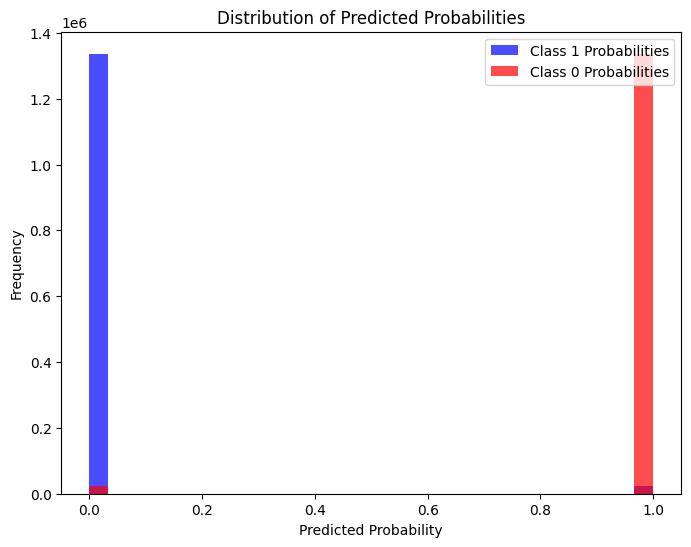

In [86]:
plt.figure(figsize=(8, 6))

# Plot the probability distribution for the class 1
plt.hist(y_final_pred[:, 1], bins=30, alpha=0.7, label='Class 1 Probabilities', color='blue')

# Optionally, you can also plot the probability distribution for class 0
plt.hist(y_final_pred[:, 0], bins=30, alpha=0.7, label='Class 0 Probabilities', color='red')

# Add title and labels
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [87]:
# I think we overfitted the model 
# Lets make a rule for churn prediction
#  tetsing things
# X['complaints'].value_counts()